# See how the model predicts...

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
from tensorflow.keras.models import load_model

In [10]:

# Some constants - listed from the training, used to normalise the data

scale = 10.083017349243164   # The mean value from the training data
offset = 5.685093402862549   # The standard deviation

length = 24 # Length of the input and output vectors (samples)

# start_date = '2022-07-18 12:00:00' # Nice example of it working well
start_date = '2022-04-08 12:00:00' 

days = 2
site_name = 'WITTERING'

sql = f"""
  select observation_ts, temperature 
    from lake.weather 
    where site_name = '{site_name}' 
    and observation_ts >= parse_datetime('{start_date}', 'yyyy-MM-dd HH:mm:ss')
    and observation_ts < DATE_ADD('day', {days}, parse_datetime('{start_date}', 'yyyy-MM-dd HH:mm:ss'))
    order by observation_ts
"""

model_filename = 'data/weather_models/model1/'


In [11]:
# Grab some data
cursor = connect(s3_staging_dir="s3://dantelore.queryresults/pyathena/",
                 region_name="eu-west-1", cursor_class=PandasCursor).cursor()

df = cursor.execute(sql).as_pandas()

# Grab the last (length * 2) items from the results
df = df[-length * 2:-1]
df['temperature'].fillna({'temperature': 0.0})

df

,observation_ts,temperature
0,2022-04-08 12:00:00,8.7
1,2022-04-08 13:00:00,8.5
2,2022-04-08 14:00:00,10.4
3,2022-04-08 15:00:00,9.8
4,2022-04-08 16:00:00,9.6
5,2022-04-08 17:00:00,8.6
6,2022-04-08 18:00:00,7.9
7,2022-04-08 19:00:00,6.2
8,2022-04-08 20:00:00,5.2
9,2022-04-08 21:00:00,4.0


2023-01-25 21:02:32.773495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-25 21:02:32.822468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


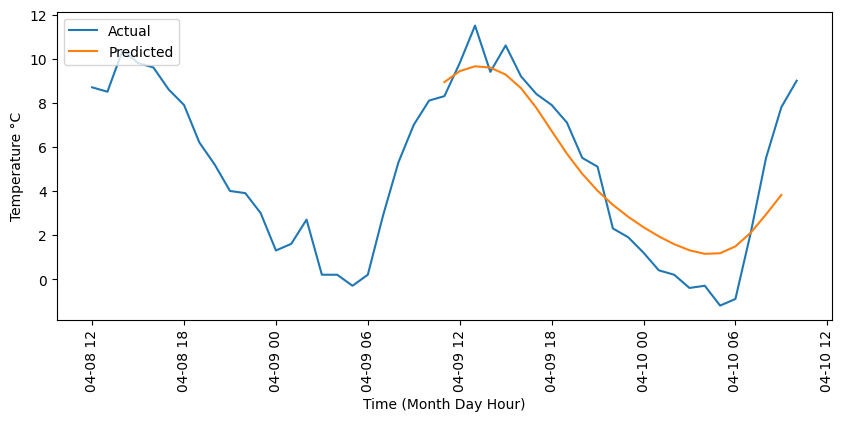

In [12]:
# Grab the first length-1 items
lead_in = df[0:length-1]

# Normalise
window = [(x - offset) / scale for x in lead_in['temperature']]

# Load the model
model = load_model(model_filename)

# Slide along, adding the latest predicted value to the end of the window
for _ in range(1, len(df) - len(window)):
    wrapped = [[x] for x in window]
    prediction = model.predict([wrapped], verbose=0).flatten()[0]

    window = window[1:]
    window.append(prediction)

# Scale it back to °C
results = [prediction * scale + offset for prediction in window]

# Cobble together the result dataframe with predicted temps and timestamps from the original data
results_df = pd.DataFrame({ 
    'temperature': results,
    'observation_ts': df['observation_ts'][len(lead_in):len(lead_in)+len(results)].to_list(),
    })

plt.figure(figsize=(10, 4))
plt.plot(df['observation_ts'], df['temperature'], label='Actual')
plt.plot(results_df['observation_ts'], results_df['temperature'], label='Predicted')
plt.ylabel('Temperature °C')
plt.xlabel('Time (Month Day Hour)')
plt.legend(loc="upper left")
plt.xticks(rotation=90)
plt.show()